In [1]:
import os
import numpy as np
import pandas as pd
from datetime import date, timedelta
import matplotlib.pyplot as plt
import scipy.io as scio
import xarray

import colorcet as cc
from cmcrameri import cm
import matplotlib.pyplot as plt
import proplot as pplt
from scipy import stats
import spotpy
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

dir_in = 'D:/Xanthos-Repo/Data for Figures-Xanthos WM'

In [2]:
#############################################################
basinName = pd.read_csv(dir_in + '/BasinNames235.txt')
basin_id = pd.read_csv(dir_in + '/basin.csv')
GRDC_xanthosCoordIndx = pd.read_csv(dir_in + '/GRDC_stations_list.csv')
Xanthos_grid_areas = np.array(pd.read_csv(dir_in + '/Grid_Areas_ID.csv'))*1e-2 #Km2
grdc_basin_m3persec  =  pd.read_csv(dir_in + '/grdc_91basin_m3persec_1971_1990_monthly.csv')

n_basin = GRDC_xanthosCoordIndx.shape[0]
basins94 = np.array(GRDC_xanthosCoordIndx['basins']).astype(np.int64)
xanthosid = np.array(GRDC_xanthosCoordIndx['xanthosID_new_adj']).astype(np.int64)
basinName_94 = [basinName['Basin_Name'][basins94[ii] - 1] for ii in range(n_basin)]

### Yaling Runoff

In [3]:
YalingRunoff = np.zeros([len(basin_id),240])
dir_usgrid = dir_in + '/UScells/contributing_grids_all'
for ii in range(235):
    data = scio.loadmat(dir_in + '/Yaling-2018-Runoff/q_235_basins/235_basins/q_1971_1990_basin_' + str(ii+1) + '.mat')
    QQdata = data['q']
    indx_yl = np.where(basin_id['basin']==(ii+1))[0]
    YalingRunoff[indx_yl, :] = QQdata

YalingRunoffBasins= np.zeros([n_basin,240])
for ii in range(n_basin):
    basin_num = basins94[ii]
    datad = (np.array(pd.read_csv(dir_usgrid + str(basin_num) + '.csv',header=None)) - 1).astype(np.int64)
    basin_idx = np.squeeze(datad) 

    #Yaling Runoff
    YalingRunoffBasins[ii,:] = np.mean(YalingRunoff[basin_idx,:], 0)     


### GRDC

In [4]:
#GRDC
grdc_mmmPermonth = np.zeros([n_basin, 240])
grdc_m3persec = np.zeros([n_basin, 240])
SI_grdc = np.zeros([n_basin,])
for ii in range(n_basin):
    
    basin_num = basins94[ii]
    datad = (np.array(pd.read_csv(dir_usgrid + str(basin_num) + '.csv',header=None)) - 1).astype(np.int64)
    basin_idx = np.squeeze(datad)
    
    aa = (grdc_basin_m3persec['basin'] == basin_num)
    us_area = np.max([GRDC_xanthosCoordIndx['US_Area_SKM'][ii], GRDC_xanthosCoordIndx['US_Area_SKM'][ii]])   
    if basin_num == 159:
        us_area = GRDC_xanthosCoordIndx['area'][ii]


    ####
    #us_area = GRDC_xanthosCoordIndx['US_Area_SKM'][ii]
    grdc_mmmPermonth[ii,:] = np.array(grdc_basin_m3persec[aa]['q'])*(30.4*24*3600)/us_area/1e3 
    grdc_m3persec[ii,:] = np.array(grdc_basin_m3persec[aa]['q'])

### filtering performance results 

In [5]:
def timeseries_coverter(data_array, start_yr, ending_yr):
    sdate = date(start_yr,1,1)
    edate = date(ending_yr, 12, 31)  
    data_ts = pd.DataFrame(data_array)
    data_ts.index = pd.date_range(start=sdate, end=edate, freq='MS')
    ##
    mean_monthly_data = np.squeeze(np.array(data_ts.groupby(data_ts.index.month).mean()))
    mean_annual_data = np.squeeze(np.array(data_ts.resample('A').sum()))

    return mean_monthly_data, mean_annual_data

In [6]:
def runoff_error(performance_data, QQmm, Qwc, qq):
    QRerror = performance_data['R'] - np.mean(QQmm) - np.mean(Qwc)
    performance_data['QRerror'] = np.abs(QRerror) / np.mean(QQmm)
    q10_wbre = performance_data['QRerror'].quantile(q=qq) 
    index1_q10_wbre = (performance_data['QRerror'] <= q10_wbre) 
    QR_filtered_performance_data = performance_data[index1_q10_wbre].reset_index(drop=True)

    return QR_filtered_performance_data

In [7]:
def peak_time_differnce(WB_filtered_performance_data, lowRII_Basins, basin_num):   
    if len(np.where(lowRII_Basins==basin_num)[0]) > 0:   
        indx_months_pt1 = ((WB_filtered_performance_data['MNTH_PDiff'] >= -1) & (WB_filtered_performance_data['MNTH_PDiff'] <= 3))
        PT_filtered_performance_data = WB_filtered_performance_data[indx_months_pt1].reset_index(drop=True)
        
        if PT_filtered_performance_data.shape[0] < 100:
            indx_months_pt2 = ((WB_filtered_performance_data['MNTH_PDiff'] >= -2) & (WB_filtered_performance_data['MNTH_PDiff'] <= 3))
            PT_filtered_performance_data = WB_filtered_performance_data[indx_months_pt2].reset_index(drop=True)
    else:
        PT_filtered_performance_data = WB_filtered_performance_data
    
    return PT_filtered_performance_data


In [8]:
def runoff_model_output(dir_data, basin_num):
    basin_calibration =  pd.read_csv(dir_data + 'basin_calibration_' + str(basin_num) + 'c.csv')
    basin_calibration = basin_calibration.drop(['para',	'parb',	'parc',	'pard',	'parm'], 1)
    ## basin_abcd
    basin_abcd = basin_calibration[['simulation1_1', 'simulation1_2', 'simulation1_3', 'simulation1_4', 'simulation1_5']]
    basin_abcd.columns = ['par_a',	'par_b',	'par_c',	'par_d',	'par_m']
    basin_calibration = basin_calibration.drop(['simulation1_1', 'simulation1_2', 'simulation1_3', 'simulation1_4', 'simulation1_5'], 1)

    ######### Runoff
    ## basin annual runoff
    no_years = 31
    basin_annaul_header = ['simulation2_' + str(ii+1) for ii in range(no_years)]
    basin_annaul_RO  = basin_calibration[basin_annaul_header]

    basin_annaul_RO.columns = np.arange(1971,2002, 1)   
    ## basin mean monthly runoff
    no_months = 12
    basin_MM_header = ['simulation3_' + str(ii+1) for ii in range(no_months)]
    basin_MM_RO   = basin_calibration[basin_MM_header]
    basin_MM_RO.columns  = [['Ja', 'Fb', 'Mr', 'Ap', 'My', 'Ju', 'Jl', 'Ag', 'Sb', 'Oc', 'Nv', 'Dc']]

    return basin_abcd, basin_annaul_RO, basin_MM_RO


In [9]:
def Rsquared_matrix(basin_annual_runoff_all, annual_ro_mat):
    aa1 = pd.DataFrame(annual_ro_mat) - np.mean(annual_ro_mat)
    mm_meanro = np.reshape(np.tile(np.mean(basin_annual_runoff_all, 1),20), 
                                  [20, basin_annual_runoff_all.shape[0]]).transpose()
    aa2 = pd.DataFrame(basin_annual_runoff_all) - mm_meanro
    aa = np.multiply(aa1,aa2).sum(axis=1)
    bb1 = (aa1**2).sum(axis=1)
    bb2 = (aa2**2).sum(axis=1)
    bb = np.sqrt(np.multiply(bb1, bb2))

    rcoeff = np.array(np.divide(aa, bb))

    return rcoeff

In [10]:
def kge_matrix(basin_annual_runoff_all, annual_ro_mat, annual_ro):    
    stdbais_annual_ro  = (1 - (np.std(basin_annual_runoff_all,1) /np.std(annual_ro)))**2
    meanbais_annual_ro = (1 - (np.mean(basin_annual_runoff_all,1) /np.mean(annual_ro)))**2
    rsquared_bias      = ( 1 - Rsquared_matrix(basin_annual_runoff_all, annual_ro_mat))**2
    ed_distance = stdbais_annual_ro + meanbais_annual_ro + rsquared_bias
    kge_value_ = 1 - np.sqrt(ed_distance)
    return kge_value_

### Filter 1 : Annual Runoff

In [11]:
def parameters_set_selection(performance_data_in, grdc_depth, basins94, basin_num): 
    # runoff data
    performance_data = performance_data_in.copy()
    bb = np.where(basins94==basin_num)[0]
    performance_data.columns = [1,2,3,4,5,6,7,8,9,10,11,12]
    performance_data['MNTH_RP'] = np.array(performance_data.idxmax(axis=1))


    #Q: Peak timing   
    QQmm, QQaa = timeseries_coverter(grdc_depth, start_yr=1971, ending_yr=1990)
    QQmm_df = pd.DataFrame(QQmm)
    QQmm_df.index = [1,2,3,4,5,6,7,8,9,10,11,12]
    performance_data['MNTH_QP'] = QQmm_df.idxmax()[0]*np.ones([performance_data.shape[0],])

    # difference
    performance_data['PT_Diff'] = performance_data['MNTH_QP'] - performance_data['MNTH_RP']

    return performance_data

In [14]:
dir_data = dir_in + '/WATCH-1M-Run-abcdm/'

start_yr = 1971
ending_yr = 1990
rmse_annual_et = np.ones([1000000, n_basin])*np.nan
kge_annual_et = rmse_annual_et.copy()
rmse_annual_ro = rmse_annual_et.copy()
kge_annual_ro = rmse_annual_et.copy()


SAVE_KWDS = {"bbox_inches": "tight", "dpi": 450, "facecolor": "w"}
n_pars = 5
sensetivity_aa = np.zeros([n_basin,n_pars])
for ii in tqdm(range(n_basin)):
    basin_num = basins94[ii]
    bb = np.where(basins94==basin_num)[0]
    ## Get data : simulated   
    basin_abcd, basin_annaul_RO, basin_MM_RO = runoff_model_output(dir_data, basin_num)

    QQmm, QQaa = timeseries_coverter(np.squeeze(grdc_mmmPermonth[bb,:]), start_yr=1971, ending_yr=1990)
    basin_annaul_RO['Qannual_error'] = np.abs(basin_annaul_RO.mean(axis=1) - np.mean(QQaa))/np.mean(QQaa)
    basin_annual_runoff = np.array(basin_annaul_RO)

    ## Get data : observed    
    mean_monthly_ro, annual_ro = timeseries_coverter(np.squeeze(grdc_mmmPermonth[bb,:]), start_yr, ending_yr)
    annual_ro_dup = np.multiply(np.ones_like(basin_annual_runoff[:,0:20]),annual_ro)
    ############ Runoff rmse
    rmse_annual_ro = np.sqrt(np.sum((basin_annual_runoff[:,0:20] - annual_ro_dup)**2, 1)  / len(annual_ro))


    #param_a  = basin_parameters['para']
    sensetivity_aa[ii,0] = np.corrcoef(basin_abcd['par_a'],rmse_annual_ro)[0,1]
    sensetivity_aa[ii,1] = np.corrcoef(basin_abcd['par_b'],rmse_annual_ro)[0,1]
    sensetivity_aa[ii,2] = np.corrcoef(basin_abcd['par_c'],rmse_annual_ro)[0,1]
    sensetivity_aa[ii,3] = np.corrcoef(basin_abcd['par_d'],rmse_annual_ro)[0,1]
    sensetivity_aa[ii,4] = np.corrcoef(basin_abcd['par_m'],rmse_annual_ro)[0,1]


100%|██████████| 91/91 [15:59<00:00, 10.54s/it]


In [19]:
file_dir_watch_vald = dir_in + '/Simulated/calibration results/basin_calibration_'

n_pars = 6
sensetivity_mmflow = np.zeros([n_basin,n_pars])
for ii in range(n_basin):
    basin_num = basins94[ii]    
    ## observed
    aa = (grdc_basin_m3persec['basin'] == basin_num)
    grdc_m3persec = np.array(grdc_basin_m3persec[aa]['q'])

    ## simulated
    data_basin = pd.read_csv(file_dir_watch_vald + str(basin_num) + '.csv')
    # best
    kge_flow = np.array(data_basin['like1'])
    #param_a  = basin_parameters['para']
    sensetivity_mmflow[ii,0] = np.corrcoef(data_basin['para'],kge_flow)[0,1]
    sensetivity_mmflow[ii,1] = np.corrcoef(data_basin['parb'],kge_flow)[0,1]
    sensetivity_mmflow[ii,2] = np.corrcoef(data_basin['parc'],kge_flow)[0,1]
    sensetivity_mmflow[ii,3] = np.corrcoef(data_basin['pard'],kge_flow)[0,1]
    sensetivity_mmflow[ii,4] = np.corrcoef(data_basin['parm'],kge_flow)[0,1]
    sensetivity_mmflow[ii,5] = np.corrcoef(data_basin['parwmbeta'],kge_flow)[0,1] 

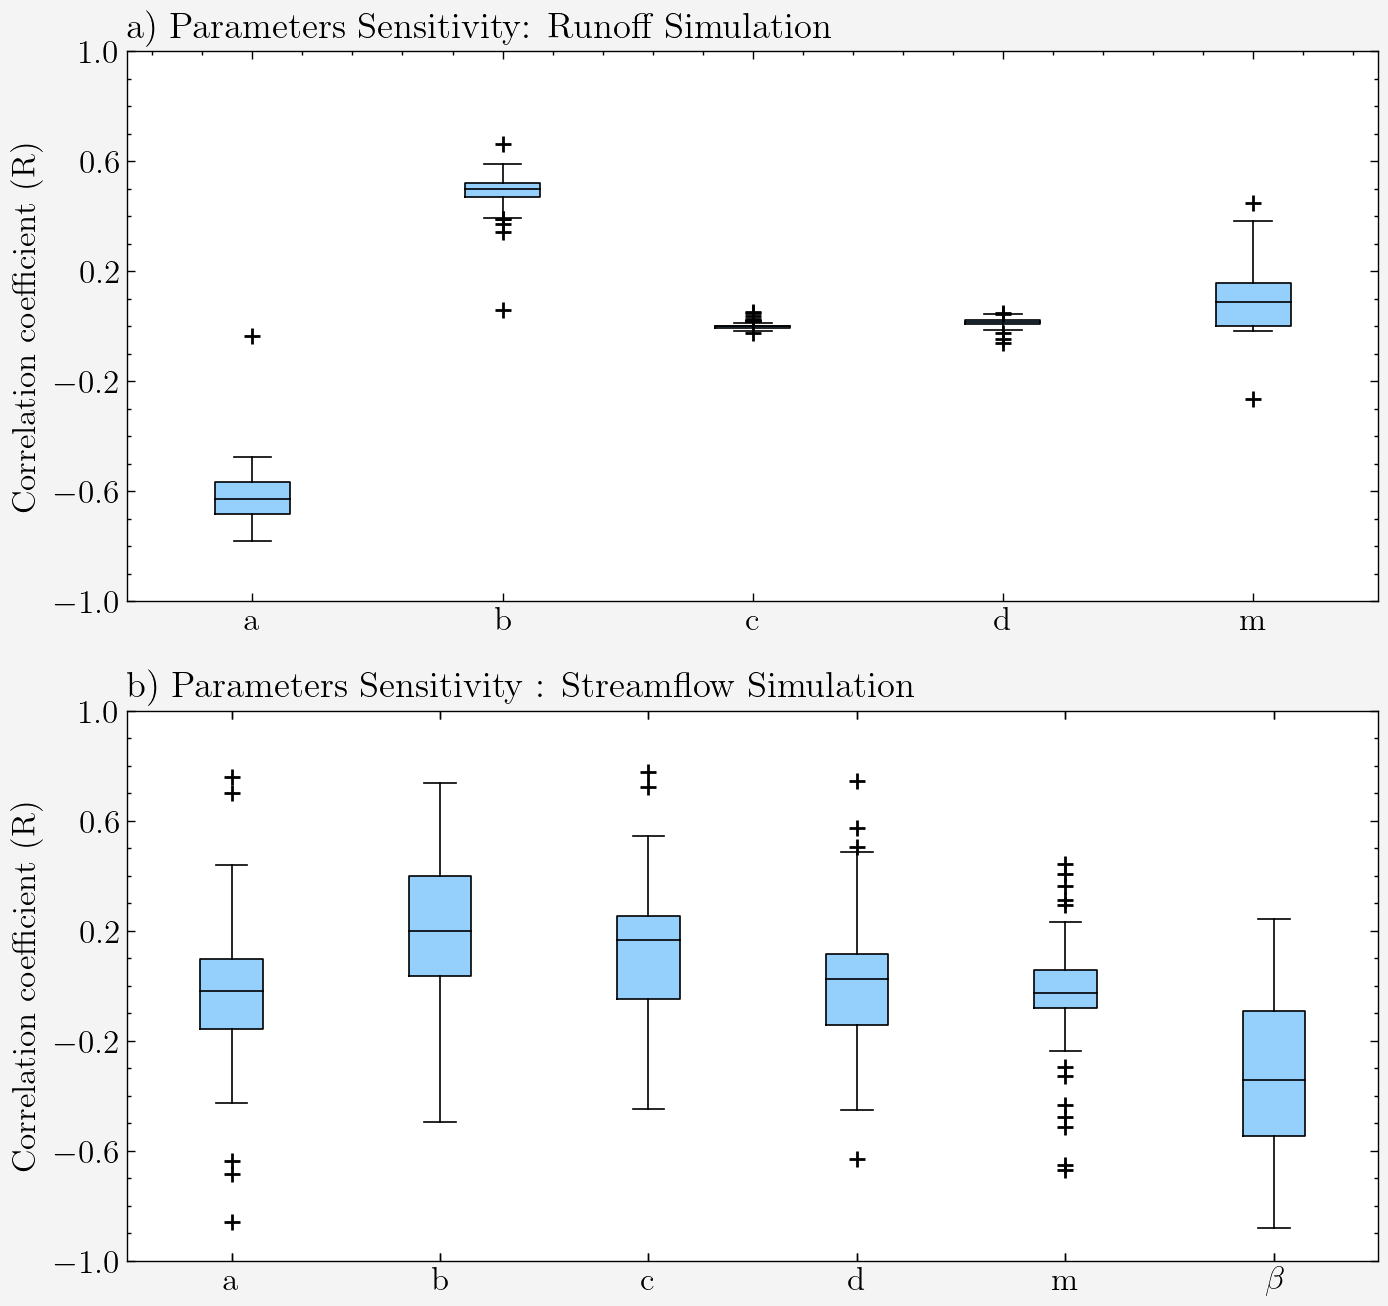

In [20]:
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.autolayout'] = True 
plt.rcParams.update({'font.size': 12}) 


sensetivity_aa_df = pd.DataFrame(sensetivity_aa)
sensetivity_aa_df.columns =  ['a', 'b', 'c', 'd', 'm']


plt.style.use('science')
## figure saving
SAVE_KWDS = {"bbox_inches": "tight", "dpi": 450, "facecolor": "w"}
## Plotting
with plt.style.context(['science', 'high-contrast']):  
    #fig, axs = pplt.subplots(ncols=2, nrows=1,refaspect=1, refheight=4.0, refwidth=4.0, share=0)
    fig, axs = pplt.subplots(nrows=2, ncols=1, refheight='2.75in', refwidth='3.5in',share=0, span=False, journal='pnas3')

    ax=axs[0]
    ax.boxplot(sensetivity_aa, sym='+', facecolor='light blue', widths = 0.3)
    ax.set_xticklabels(['a','b','c','d','m'])
    ax.set_ylim([-1,1])
    ax.format(title='Parameters Sensitivity: Runoff Simulation',ylabel = 'Correlation coefficient (R)', 
              abcstyle='a)', titleloc='l', fontsize=12, ylocator = np.arange(-1, 1.001, 0.4), grid='off')
    ax.tick_params(axis='both', which='major', labelsize=12)
    #ax.minorticks_off()
    ax.xaxis.set_tick_params(which='minor', bottom=False)



    ####################
    ax=axs[1]
    sensetivity_mmflow_df = pd.DataFrame(sensetivity_mmflow)
    sensetivity_mmflow_df.columns =  ['a', 'b', 'c', 'd', 'm', r'$\beta$']

    ax.boxplot(sensetivity_mmflow_df, sym='+', facecolor='light blue', widths = 0.3)

    ax.set_ylim([-1,1])
    ax.format(title='Parameters Sensitivity : Streamflow Simulation', ylabel = 'Correlation coefficient (R)', 
              abcstyle='a)', titleloc='l', fontsize=12, ylocator = np.arange(-1, 1.001, 0.4), grid='off')
    ax.tick_params(axis='both', which='major', labelsize=12)
    #ax.minorticks_off()
    ax.xaxis.set_tick_params(which='minor', bottom=False)


fig.align_ylabels(axs)
plt.tight_layout()

#dir_out = 'D:\\Xanthos-Repo\\figures\\'
#plt.savefig(dir_out + "Figure-12.png", **SAVE_KWDS)     